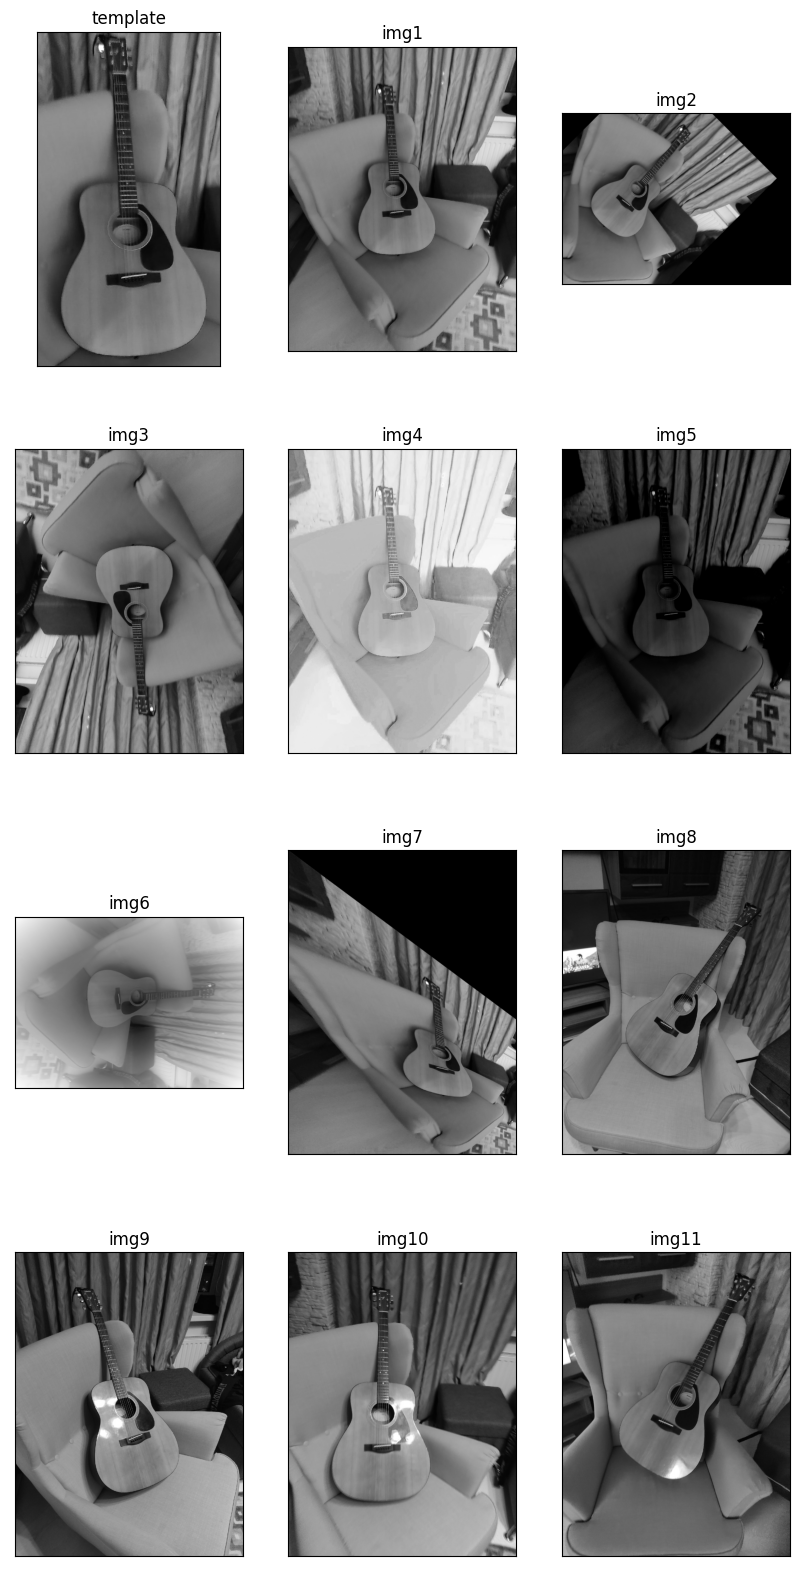

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

images = []
titles = []
images.append(cv2.imread("data/img1.1.jpg", 0))
for i in range(1,12):
    images.append(cv2.imread("data/img" + str(i) + ".jpg", 0))

titles.append("template")
for i in range(1,12):
    titles.append("img" + str(i))
    
plt.figure(figsize=(10,20))
for i in range(12):
    plt.subplot(4,3,i+1),plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


# Template matching

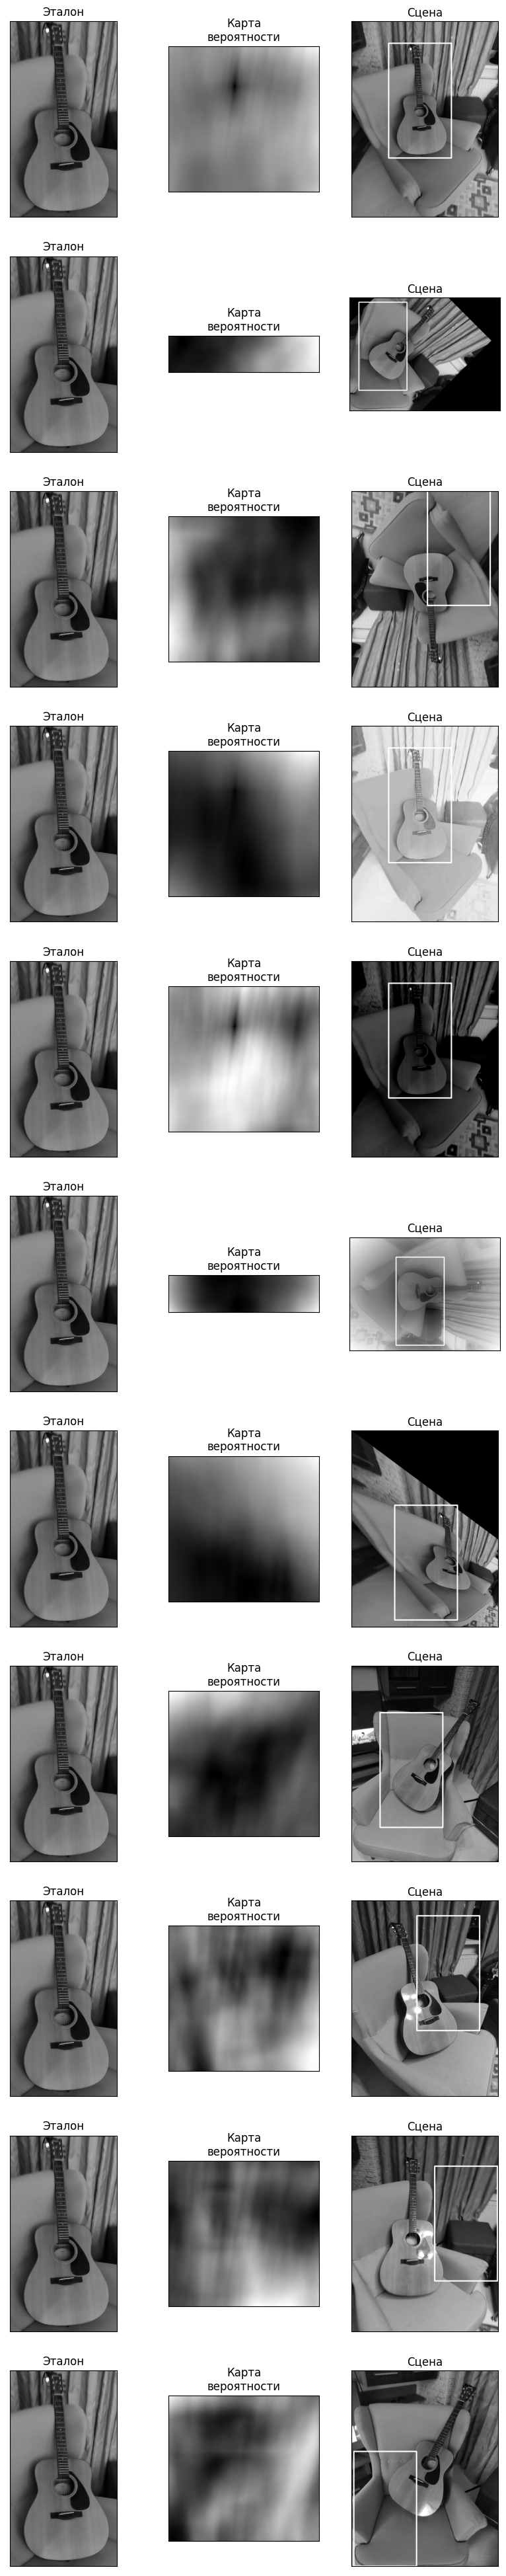

In [8]:
results = []
for i in range (1, len(images)):
    res = cv2.matchTemplate(images[i], images[0], cv2.TM_SQDIFF)
    _, _, min_loc, _ = cv2.minMaxLoc(res) #используем метод TM_SQDIFF
    top_left = min_loc 
    bottom_right = (top_left[0] + images[0].shape[1], top_left[1] + images[0].shape[0])
    img_rec = images[i].copy()
    cv2.rectangle(img_rec, top_left, bottom_right, 255, 10)
    results.append([images[0], res, img_rec])
    
fig, axes = plt.subplots(nrows = 11, ncols =3, figsize=(10,50))

for i in range(len(results)):
    for j in range(len(results[0])):
        if j == 0:
            axes[i,j].imshow((cv2.cvtColor(results[i][j], cv2.COLOR_BGR2RGB)))
            axes[i,j].set(title='Эталон')
        if j == 1:
            axes[i,j].imshow(results[i][j], cmap='gray')
            axes[i,j].set(title='Карта\nвероятности')
        if j == 2:
            axes[i,j].imshow((cv2.cvtColor(results[i][j], cv2.COLOR_BGR2RGB)))
            axes[i,j].set(title='Сцена')
            
for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
plt.show()

# ORB

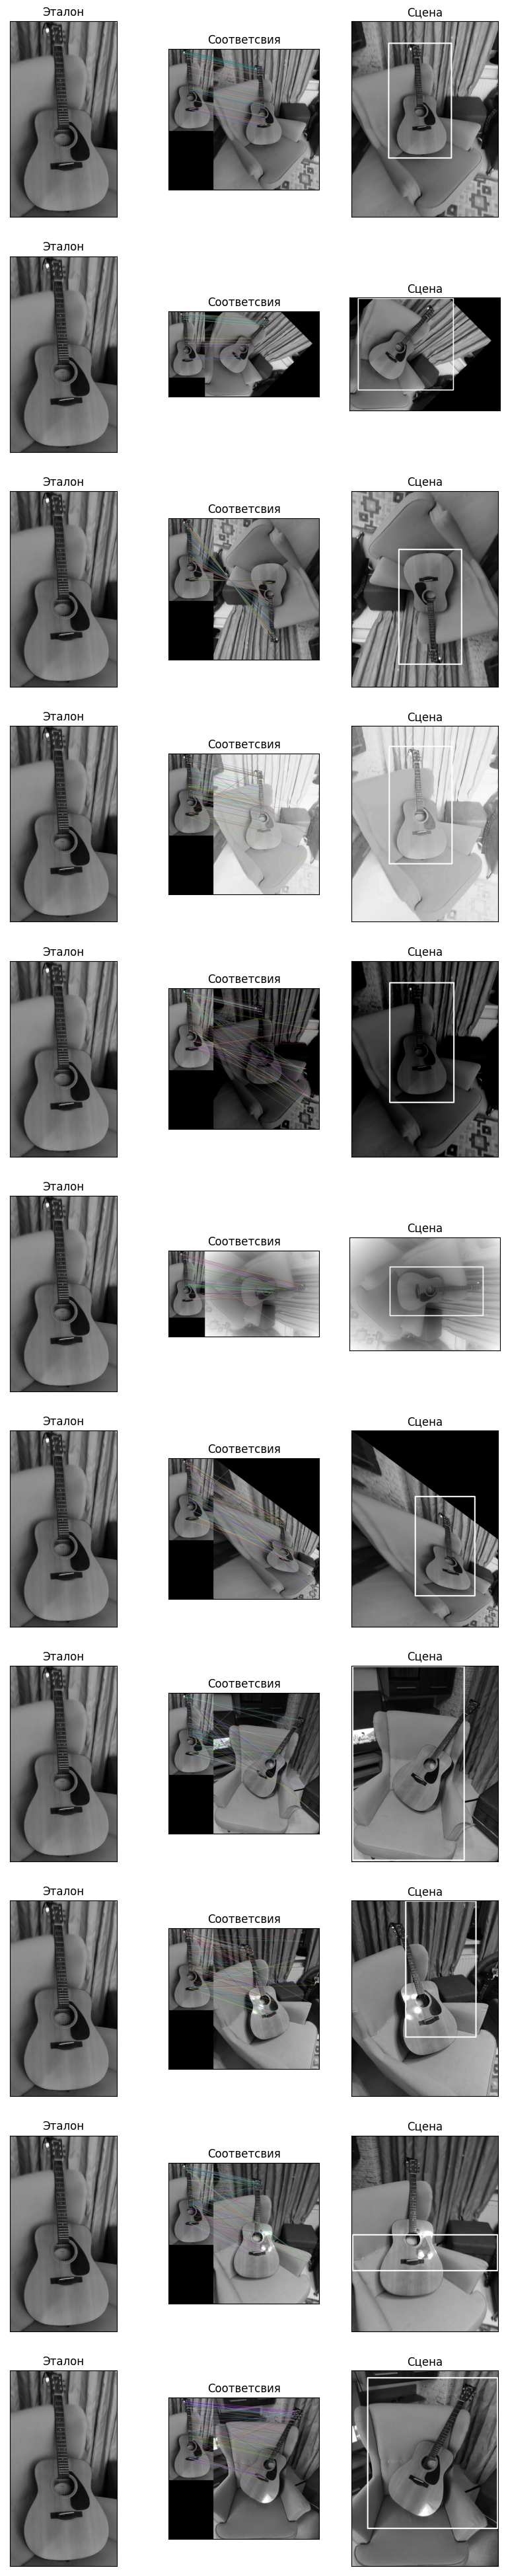

In [9]:
results_ORB = []
for i in range (1, len(images)):
# Инициализируем ORB
    orb = cv2.ORB_create()

    # Находим ключевые точки и дескрипторы с помощью ORB
    kp_template, des_template = orb.detectAndCompute(images[0],None)
    kp_image, des_image = orb.detectAndCompute(images[i],None)

    # Инициализируем BFMatcher 
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Находим соответсвия между дескрипторами
    matches = bf.match(des_template,des_image)

    # Сортируем соответсвия по дистанции от меньшей к большей
    matches = sorted(matches, key = lambda x:x.distance)

    # Рисуем первые 100 соответсвий.
    result = cv2.drawMatches(images[0],kp_template,images[i],kp_image,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    #Записываем первые 10 соответсвий с эталона и исходного изображения
    src_pts = np.float32([ kp_template[m.queryIdx].pt for m in matches[:10] ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_image[m.trainIdx].pt for m in matches[:10] ]).reshape(-1,1,2)

    # Рассчитываем матрицу гомографии
    h, _ = cv2.findHomography(src_pts, dst_pts)


    rectangle_pts = np.float32([[0, 0], 
                                [0,images[0].shape[0]],
                                [images[0].shape[1],0],
                                [images[0].shape[1],images[0].shape[0]]]).reshape(-1,1,2)

    rectangle_pts = cv2.perspectiveTransform(rectangle_pts,h).reshape(-1,2)

    #Находим углы рамки
    left_top = [images[i].shape[1],images[i].shape[0]]
    right_bottom = [0,0]

    for point in  rectangle_pts:
        #Находим левую верхнюю точку рамки
        if point[0] < left_top[0]:
            left_top[0] = point[0] if point[0] >= 0 else 0
        if point[1] < left_top[1]:
            left_top[1] = point[1] if point[1] >= 0 else 0

        #Находим правую нижнюю точку рамки
        if point[0] > right_bottom[0]:
            right_bottom[0] = point[0] if point[0] <= images[i].shape[1] else images[i].shape[1]
        if point[1] > right_bottom[1]:
            right_bottom[1] = point[1] if point[1] <= images[i].shape[0] else images[i].shape[0]
        
    #Чтобы рамку было видно у края изображения:
    left_top = [int(left_top[0]),int(left_top[1])]
    if left_top[0] == 0:
        left_top[0] += 10
    if left_top[1] == 0:
        left_top[1] += 10

    right_bottom = [int(right_bottom[0]),int(right_bottom[1])]
    if right_bottom[0] == images[i].shape[1]:
        right_bottom[0] -= 10
    if right_bottom[1] == images[i].shape[0]:
        right_bottom[1] -= 10


    #Чертим рамку
    img_rec = images[i].copy()
    cv2.rectangle(img_rec, left_top, right_bottom, 255, 10) 
    
    results_ORB.append([images[0],result,img_rec])

fig, axes = plt.subplots(nrows = 11, ncols =3, figsize=(10,50))

for i in range(len(results_ORB)):
    for j in range(len(results_ORB[0])):
        axes[i,j].imshow((cv2.cvtColor(results_ORB[i][j], cv2.COLOR_BGR2RGB)))
        if j == 0:
            axes[i,j].set(title='Эталон')
        if j == 1:
            axes[i,j].set(title='Соответсвия')
        if j == 2:
            axes[i,j].set(title='Сцена')
            
for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
plt.show()
